<a href="https://colab.research.google.com/github/serafinazhang/Find_similar_questions/blob/main/Finding_similar_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finding Similar Questions**
Junqian Zhang

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
!pip install pyspark
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, countDistinct, udf, lower, regexp_replace, size
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, MinHashLSH, RegexTokenizer
from pyspark.sql.types import *
import time

In [ ]:
! pip install pandasql

In [ ]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, glob als())

In [ ]:
from google.colab import files

# 1. Spark Environment Setup

In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q http://www-eu.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.0-bin-hadoop2.7.tgz

!rm spark-3.2.0-bin-hadoop2.7.tgz

!pip install -q findspark

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
#SparkSession initialization
conf = SparkConf().setAppName("similar_questions")
spark = SparkSession.builder.enableHiveSupport().config(conf = conf).getOrCreate()
sc = spark.sparkContext
type(sc)

pyspark.context.SparkContext

# 2. Data Loading

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d stackoverflow/stacksample

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 1.11G/1.11G [00:09<00:00, 126MB/s]
100% 1.11G/1.11G [00:09<00:00, 119MB/s]


In [ ]:
from zipfile import ZipFile
with ZipFile("stacksample.zip", 'r') as zip:
  zip.printdir()
  zip.extract("Questions.csv")
! rm stacksample.zip

File Name                                             Modified             Size
Answers.csv                                    2019-10-08 00:40:36   1607914819
Questions.csv                                  2019-10-08 00:43:12   1923682009
Tags.csv                                       2019-10-08 00:46:14     65475836


In [ ]:
df = spark.read\
  .option("multiLine", "true")\
  .option("header", "true")\
  .option("escape", "\"")\
  .csv("Questions.csv")\
  .select("Id", "Body")

df.printSchema()
df.show(10)

root
 |-- Id: string (nullable = true)
 |-- Body: string (nullable = true)

+---+--------------------+
| Id|                Body|
+---+--------------------+
| 80|<p>I've written a...|
| 90|<p>Are there any ...|
|120|<p>Has anyone got...|
|180|<p>This is someth...|
|260|<p>I have a littl...|
|330|<p>I am working o...|
|470|<p>I've been writ...|
|580|<p>I wonder how y...|
|650|<p>I would like t...|
|810|<p>I'm trying to ...|
+---+--------------------+
only showing top 10 rows



In [ ]:
df.count()

1264216

In [ ]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Body: string (nullable = true)



# 3. Data Cleaning

In [ ]:
# check missing values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+----+
| Id|Body|
+---+----+
|  0|   0|
+---+----+



In [ ]:
def clean_text(x):
  x = regexp_replace(x, '<.*?>', '')
  x = regexp_replace(x, '\n|\r', '')
  x = regexp_replace(x, '[^a-zA-Z\\s]', ' ')
  return x

df_clean = df.select('Id', clean_text(col("Body")).alias("Body"))

In [ ]:
tokenizer = Tokenizer().setInputCol("Body").setOutputCol("Tokens")
df_token = tokenizer.transform(df_clean)

In [ ]:
swr = StopWordsRemover(inputCol = 'Tokens', outputCol = 'No_Stopwords')
df_swr = swr.transform(df_token)
df_swr.show(5)

+---+--------------------+--------------------+--------------------+
| Id|                Body|              Tokens|        No_Stopwords|
+---+--------------------+--------------------+--------------------+
| 80|I ve written a da...|[i, ve, written, ...|[ve, written, dat...|
| 90|Are there any rea...|[are, there, any,...|[really, good, tu...|
|120|Has anyone got ex...|[has, anyone, got...|[anyone, got, exp...|
|180|This is something...|[this, is, someth...|[something, ve, p...|
|260|I have a little g...|[i, have, a, litt...|[little, game, wr...|
+---+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
import pyspark.sql.functions as F
df_nd = df_swr.withColumn("No_Duplicates", F.array_distinct("No_Stopwords"))
df_nd.show(5)

+---+--------------------+--------------------+--------------------+--------------------+
| Id|                Body|              Tokens|        No_Stopwords|       No_Duplicates|
+---+--------------------+--------------------+--------------------+--------------------+
| 80|I ve written a da...|[i, ve, written, ...|[ve, written, dat...|[ve, written, dat...|
| 90|Are there any rea...|[are, there, any,...|[really, good, tu...|[really, good, tu...|
|120|Has anyone got ex...|[has, anyone, got...|[anyone, got, exp...|[anyone, got, exp...|
|180|This is something...|[this, is, someth...|[something, ve, p...|[something, ve, p...|
|260|I have a little g...|[i, have, a, litt...|[little, game, wr...|[little, game, wr...|
+---+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df_nd.count()

1264216

# 4. Locality Sensitive Hashing

In [ ]:
question = df_nd.select('Id', 'No_Duplicates')

In [ ]:
ss = 2000
sample_size = []
for i in range(11):
  sample_size.append(ss)
  ss = ss + 2000

In [ ]:
sample_size

[2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000]

In [ ]:
computation_time = []
for s in sample_size:
  start = time.time()
  print('Sample Size: ' + str(s))

  question_p = question.limit(s) 
  
  # Feature extraction
  hashingTF = HashingTF(inputCol="No_Duplicates", outputCol="Features", numFeatures=1024)
  featurizedData = hashingTF.transform(question_p)

  # MinHash for Jaccard distance
  mh = MinHashLSH(inputCol="Features", outputCol="hashes")
  model = mh.fit(featurizedData)
  hash = model.transform(featurizedData)

  # Compute the locality sensitive hashes for the input rows and perform approximate similarity join
  match = model.approxSimilarityJoin(hash, hash, 0.5, distCol="JaccardDistance")\
              .select(col("datasetA.id").alias("idA"),
                      col("datasetB.id").alias("idB"),
                      col("JaccardDistance")).filter('idA < idB')
  match.sort(match.JaccardDistance.asc()).show(10)

  end = time.time()

  t = round(end-start, 2)
  computation_time.append(t)
  print("Computation Time: {} seconds".format(t))
  print("=======================================")

Sample Size: 2000


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+---+---+---------------+
|idA|idB|JaccardDistance|
+---+---+---------------+
+---+---+---------------+

Computation Time: 10.13 seconds
Sample Size: 4000
+---+---+---------------+
|idA|idB|JaccardDistance|
+---+---+---------------+
+---+---+---------------+

Computation Time: 8.84 seconds
Sample Size: 6000
+---+---+---------------+
|idA|idB|JaccardDistance|
+---+---+---------------+
+---+---+---------------+

Computation Time: 15.32 seconds
Sample Size: 8000
+------+------+------------------+
|   idA|   idB|   JaccardDistance|
+------+------+------------------+
|446500|446600|0.4666666666666667|
+------+------+------------------+

Computation Time: 21.95 seconds
Sample Size: 10000
+------+------+------------------+
|   idA|   idB|   JaccardDistance|
+------+------+------------------+
|446500|446600|0.4666666666666667|
+------+------+------------------+

Computation Time: 30.19 seconds
Sample Size: 12000
+------+------+------------------+
|   idA|   idB|   JaccardDistance|
+------+----

In [ ]:
ss = 24000
sample_size1 = []
for i in range(11):
  sample_size1.append(ss)
  ss = ss + 2000

In [ ]:
computation_time1 = []
for s in sample_size1:
  start = time.time()
  print('Sample Size: ' + str(s))

  question_p = question.limit(s) 
  
  # Feature extraction
  hashingTF = HashingTF(inputCol="No_Duplicates", outputCol="Features", numFeatures=1024)
  featurizedData = hashingTF.transform(question_p)

  # MinHash for Jaccard distance
  mh = MinHashLSH(inputCol="Features", outputCol="hashes")
  model = mh.fit(featurizedData)
  hash = model.transform(featurizedData)

  # Compute the locality sensitive hashes for the input rows and perform approximate similarity join
  match = model.approxSimilarityJoin(hash, hash, 0.5, distCol="JaccardDistance")\
              .select(col("datasetA.id").alias("idA"),
                      col("datasetB.id").alias("idB"),
                      col("JaccardDistance")).filter('idA < idB')
  match.sort(match.JaccardDistance.asc()).show(10)

  end = time.time()

  t = round(end-start, 2)
  computation_time1.append(t)
  print("Computation Time: {} seconds".format(t))
  print("=======================================")

Sample Size: 24000


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------+-------+-------------------+
|    idA|    idB|    JaccardDistance|
+-------+-------+-------------------+
|1041520|1042370|0.32558139534883723|
| 950210| 950960|           0.453125|
| 446500| 446600| 0.4666666666666667|
|1063190| 711820| 0.4878048780487805|
+-------+-------+-------------------+

Computation Time: 143.22 seconds
Sample Size: 26000
+-------+-------+-------------------+
|    idA|    idB|    JaccardDistance|
+-------+-------+-------------------+
|1041520|1042370|0.32558139534883723|
| 950210| 950960|           0.453125|
| 446500| 446600| 0.4666666666666667|
|1063190| 711820| 0.4878048780487805|
+-------+-------+-------------------+

Computation Time: 161.32 seconds
Sample Size: 28000
+-------+-------+-------------------+
|    idA|    idB|    JaccardDistance|
+-------+-------+-------------------+
|1041520|1042370|0.32558139534883723|
| 950210| 950960|           0.453125|
| 446500| 446600| 0.4666666666666667|
|1063190| 711820| 0.4878048780487805|
|1411730|1415520| 0.

In [ ]:
computation_time

[10.13, 8.84, 15.32, 21.95, 30.19, 41.15, 52.71, 68.63, 85.9, 102.0, 119.07]

In [ ]:
computation_time1

[143.22,
 161.32,
 187.33,
 209.76,
 236.0,
 269.23,
 299.59,
 332.19,
 358.62,
 400.39,
 437.55]

In [ ]:
computation_time = [10.13, 8.84, 15.32, 21.95, 30.19, 41.15, 52.71, 68.63, 85.9, 102.0, 119.07]
computation_time1 = [143.22, 161.32, 187.33, 209.76, 236.0, 269.23, 299.59, 332.19, 358.62, 400.39,437.55]

In [ ]:
all_time = computation_time[:] + computation_time1[:]

In [ ]:
all_sample = sample_size[:] + sample_size1[:]

In [ ]:
summary = pd.DataFrame({"Sample Size": all_sample, "Computation Time": all_time})

In [ ]:
summary

,Sample Size,Computation Time
0,2000,10.13
1,4000,8.84
2,6000,15.32
3,8000,21.95
4,10000,30.19
5,12000,41.15
6,14000,52.71
7,16000,68.63
8,18000,85.90
9,20000,102.00


# 5. Exhaustive Search

In [ ]:
exact = question.limit(2000).toPandas()

In [ ]:
def jaccard_distance(x, y):
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    similarity = intersection.sum() / float(union.sum())
    return 1-similarity

In [ ]:
q = """SELECT df1.id AS idA, df2.id AS idB
FROM compare df1, compare df2 ON (idA < idB)
"""

In [ ]:
start = time.time()
df = pd.DataFrame({"text":list(exact['No_Duplicates'])})
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x]))
df['text'] = df['text'].apply(lambda x: str(x))
start = time.time()
vectorizer = CountVectorizer(max_features = 1024)
X = vectorizer.fit_transform(list(df['text']))
tf_array = pd.DataFrame(X.T.toarray())
feature = []
for i in range(2000):
  feature.append(list(tf_array[i]))
compare = pd.DataFrame({"id": exact['Id']})
compare2 = pd.DataFrame({"id": exact['Id'],'feature': feature})
match = pysqldf(q)
M = pd.merge(match, compare2, left_on='idA', right_on='id')
M = pd.merge(M, compare2, left_on='idB', right_on='id')
M = M.drop(['id_x', 'id_y'], axis = 1)
jac_d = []
for i in range(len(M)):
  d = jaccard_distance(M['feature_x'][i], M['feature_y'][i])
  jac_d.append(d)

M['distance'] = jac_d

end = time.time()

In [ ]:
vectorizer.get_feature_names_out()

array(['able', 'accepted', 'access', ..., 'years', 'yes', 'yet'],
      dtype=object)

In [ ]:
round(end-start, 2)

745.45

In [ ]:
exact = question.limit(4000).toPandas()

In [ ]:
start = time.time()
df = pd.DataFrame({"text":list(exact['No_Duplicates'])})
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x]))
df['text'] = df['text'].apply(lambda x: str(x))
start = time.time()
vectorizer = CountVectorizer(max_features = 1024)
X = vectorizer.fit_transform(list(df['text']))
tf_array = pd.DataFrame(X.T.toarray())
feature = []
for i in range(4000):
  feature.append(list(tf_array[i]))
compare = pd.DataFrame({"id": exact['Id']})
compare2 = pd.DataFrame({"id": exact['Id'],'feature': feature})
match = pysqldf(q)
M = pd.merge(match, compare2, left_on='idA', right_on='id')
M = pd.merge(M, compare2, left_on='idB', right_on='id')
M = M.drop(['id_x', 'id_y'], axis = 1)
jac_d = []
for i in range(len(M)):
  d = jaccard_distance(M['feature_x'][i], M['feature_y'][i])
  jac_d.append(d)

M['distance'] = jac_d

end = time.time()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [ ]:
round(end-start, 2)

2991.04

In [ ]:
len(M)

7998000

In [ ]:
computation_time2 = [745.45, 2991.04] + 20* [0]
summary['exhaustive'] = computation_time2

In [ ]:
summary = summary.replace(0, np.nan)

# 6. Performance Comparison

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


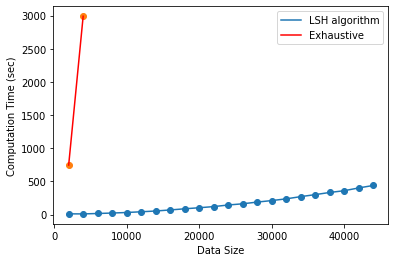

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

x = summary['Sample Size']
y = summary['Computation Time']
plt.plot(x, y, label="LSH algorithm")
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# plt.plot(x,p(x),"g--", label="linear trend")
plt.scatter(x, summary['exhaustive'])
plt.plot(x, summary['exhaustive'], label = 'Exhaustive', color="red")

plt.xlabel("Data Size")
plt.ylabel("Computation Time (sec)")


leg = plt.legend()

# save the plot
plt.savefig('result1.eps')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


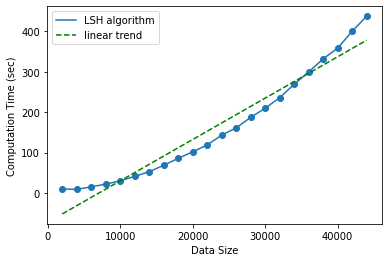

In [ ]:
x = summary['Sample Size']
y = summary['Computation Time']
plt.plot(x, y, label="LSH algorithm")
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"g--", label="linear trend")

#plt.plot(x, summary['exhaustive'], label = 'Exhaustive', color="red")

plt.xlabel("Data Size")
plt.ylabel("Computation Time (sec)")


leg = plt.legend()

# save the plot
plt.savefig('result2.eps')

plt.show()

# 7. Explore similar pairs found by LSH

In [ ]:
1041520 & 1042370

In [ ]:
df_nd.where((col("id") == 446500) | (col("id") == 446600)).show(truncate=False)

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_nd.where((col("id") == 950210) | (col("id") == 950960)).show(truncate=False)

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_nd.where((col("id") == 1041520) | (col("id") == 1042370)).show(truncate=False)

+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------